# Finding crypto assets price correlations in blockchain metrics
This tutorial extends the tutorial by [Quynh](https://blog.cryptocompare.com/@cryptoqween) on [Calculating NVT Ratios with the CryptoCompare API](https://blog.cryptocompare.com/how-to-calculate-nvt-ratios-with-the-cryptocompare-api-870d6d6b3c86).

In this tutorial, we explore the blockchain data and highlight interesting metrics that may correlate with crypto prices.

Specifically, we looked at prices against:
- NVT signal (NVTS)
- Active addresses
- Large blockchain transactions

This tutorial uses the CryptoCompare Blockchain data API. The dataset is powered by our partner, [Into The Block](https://www.intotheblock.com/) — an intelligence company that leverages machine learning and advanced statistics to extract intelligent signals for crypto-assets.

In [1]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Get API key
You can only access the blockchain data with a valid API key. [Read this guide](https://www.cryptocompare.com/coins/guides/how-to-use-our-api/) on getting an API key.

In [2]:
# Replace your API key
api_key = "YOUR_API_KEY_HERE"

## Available coins
For a list of coins available for blockchain data, you may use the following endpoint:

https://min-api.cryptocompare.com/data/blockchain/list

In [3]:
symbol = "BTC"
limit = 1000 # Number of data points to return

In [4]:
def get_blk_px_data(api_key, symbol, limit):
    blockchain_data_url = f"https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym={symbol}&limit={limit}&api_key={api_key}"
    price_data_url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym=USD&limit={limit}&api_key={api_key}"

    blk_data = requests.get(blockchain_data_url).json()["Data"]["Data"]
    price_data = requests.get(price_data_url).json()["Data"]["Data"]

    # Data preparations
    df_blk = pd.DataFrame(blk_data)
    df_price = pd.DataFrame(price_data)
    df_blk["datetime"] = pd.to_datetime(df_blk["time"], unit="s")
    df_blk = df_blk.set_index("datetime")
    df_price["datetime"] = pd.to_datetime(df_price["time"], unit="s")
    df_price = df_price.drop(columns="time")
    df_price = df_price.set_index("datetime")
    df = df_blk.join(df_price)
    
    return df

In [5]:
df = get_blk_px_data(api_key, symbol, limit)

In [6]:
df.head()

,id,symbol,time,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,...,block_size,current_supply,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-14,1182,BTC,1492128000,224070870,247460274,390738,705778,290208,213331528,4858,...,995109,1.627389e+07,1195.40,1162.16,1176.20,47217.49,56129576.67,1177.33,direct,
2017-04-15,1182,BTC,1492214400,224385398,247811775,351501,689879,270705,213602233,3150,...,991701,1.627576e+07,1194.85,841.53,1177.33,28384.58,33877537.21,1176.99,direct,
2017-04-16,1182,BTC,1492300800,224658276,248093221,281446,595592,211829,213814062,3644,...,927419,1.627759e+07,1187.97,1166.74,1176.99,18930.29,22538918.55,1176.80,direct,
2017-04-17,1182,BTC,1492387200,224937298,248421085,327864,608594,245184,214059246,4362,...,930786,1.627931e+07,1202.97,1172.81,1176.80,46483.54,56095607.39,1194.01,direct,
2017-04-18,1182,BTC,1492473600,225273357,248818359,397274,715616,303091,214362337,5804,...,955539,1.628114e+07,1213.88,1191.14,1194.01,52747.52,64900219.25,1206.09,direct,


## Blockchain metrics

The following blockchain metrics are provided via the CryptoCompare API:
- zero_balance_addresses_all_time
- unique_addresses_all_time
- new_addresses
- active_addresses
- average_transaction_value
- block_height
- hashrate
- difficulty
- block_time
- block_size
- current_supply
- transaction_count
- transaction_count_all_time
- large_transaction_count

[Full descriptions of the return fields are available here](https://www.cryptocompare.com/media/36639879/itb_blockchain_data_dictionary.pdf)

## NVT signal (NVTS)

NVT (Network Value to Transaction Ratio) is created and popularised by [Willy Woo](https://woobull.com/introducing-nvt-ratio-bitcoins-pe-ratio-use-it-to-detect-bubbles/) to measure whether a network is over-valued or under-valued. It is similar to the price-earnings ratio (PE ratio) used for companies. It compares the value perceived of the network against how much the network is used.

> NVT = Network Value / Daily Transaction Value

In a [blog post](https://medium.com/cryptolab/https-medium-com-kalichkin-rethinking-nvt-ratio-2cf810df0ab0), Dmitry Kalichkin further refined the metric in an attempt to detect crypto bubbles. He argues that a longer moving average (MA) helps smoothing reflexive effects by short term price movements and reflects the fundamental utility of the network better, the [NVT Signal (NVTS)](https://charts.woobull.com/bitcoin-nvt-signal/).

> NVTS = Network Value / 90-Days MA of Transaction Value

He also examined cases where NVTS may not work well and explained that strong trend or external news are usually the reasons.

Further, he mentioned that one of the fundamental weaknesses of NVT is, not taking into account the number of addresses participating in the transactions - the Daily Active Addresses, which we will have a look in the next section.

In [7]:
dma = 90
def calc_nvts(df, dma):
    df[f"{dma}dma_usd_txn_value"] = (df["transaction_count"] * df["average_transaction_value"] * df["close"]).rolling(window=dma).mean()
    df["nvts"] = (df["current_supply"] * df["close"]) / df[f"{dma}dma_usd_txn_value"]
    return df

In [8]:
df = calc_nvts(df, dma)

Text(0.5, 1.0, 'BTC NVTS vs Price (Daily)')

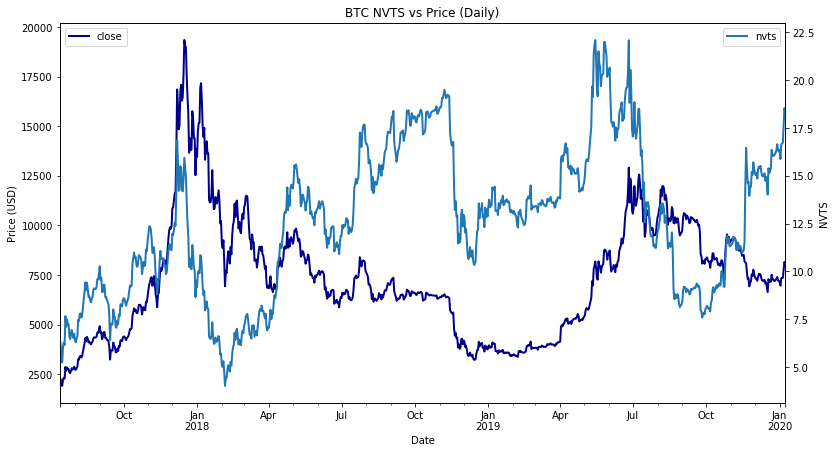

In [9]:
# Plot NVTS vs price
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
df["close"].iloc[dma:].plot(color='darkblue', linewidth=2)
ax1 = ax.twinx()
df["nvts"].iloc[dma:].plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("NVTS")
plt.title(f"{symbol} NVTS vs Price (Daily)")

## Active addresses
[Metcalfe's law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) states that the effect of a network is proportional to the square of number of users in the system. There are different variants of Metcalfe's Law but the idea is the value of the network is a function of the number of active users.

Let's looking at how the price correlate with number of active addresses over time.

Text(0.5, 1.0, 'BTC Active addresses vs Price (Daily)')

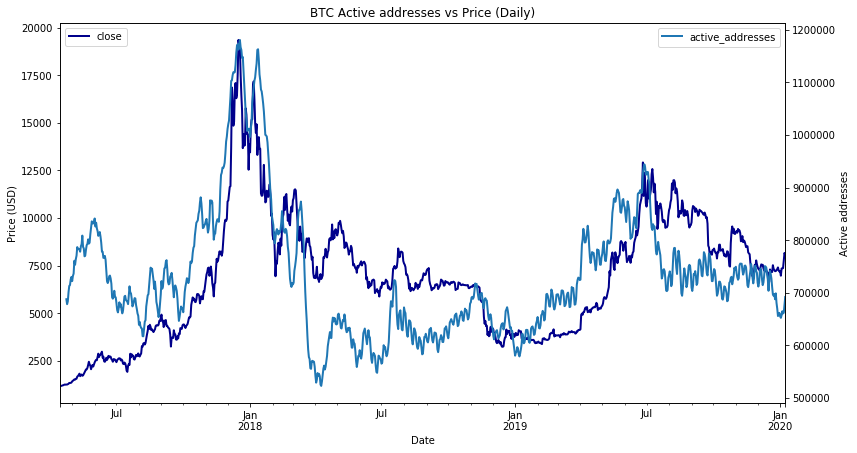

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
df["close"].plot(linewidth=2, color='darkblue')
ax1 = ax.twinx()
# Plot active addresses as a MA to reduce noise
df["active_addresses"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("Active addresses")
plt.title(f"{symbol} Active addresses vs Price (Daily)")

From the graph above, active addresses seems to correlate with the peaks and troughs of the prices quite well and seems to precede the price on some occasion.

## Large blockchain transactions

Another metric which seems to correlate well with the price is the percentage of large transactions.

In [11]:
df["large_txn_pct"] = df["large_transaction_count"] / df["transaction_count"] * 100

Text(0.5, 1.0, 'BTC Percentage of large transactions vs Price (Daily)')

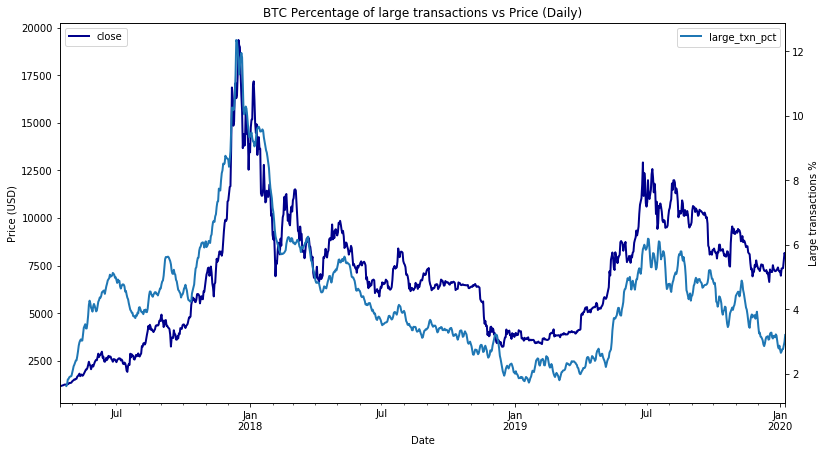

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))
df["close"].plot(linewidth=2, color='darkblue')
ax1 = ax.twinx()
# Plot percentage of large transactions as a MA to reduce noise
df["large_txn_pct"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("Large transactions %")
plt.title(f"{symbol} Percentage of large transactions vs Price (Daily)")

From the graph, despite the correlation, it is unclear whether price is leading, preceding or move in tandem with the price.

Note that "Large transactions" is defined by transactions > 100,000 USD.

Since it is a static number, it follows that when the price increases, given the same amount of BTC transacted, the percentage of "Large transactions" also increases.

An alternative measurement may be measuring large transactions by amount in the native coin unit.

In [13]:
# Assume all large transactions are worth 100,000 USD
large_txn_dollar = 100000
df[f"large_txn_{symbol}"] = df["large_transaction_count"] * large_txn_dollar / df["close"]

Text(0.5, 1.0, 'Large transactions in BTC vs Price')

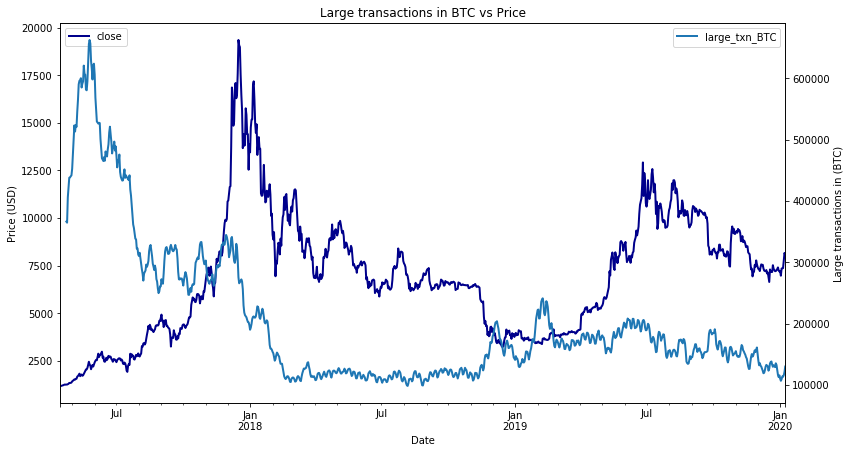

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7), sharex='row')
df["close"].plot(linewidth=2, color="darkblue")
ax1 = ax.twinx()
df[f"large_txn_{symbol}"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)

ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel(f"Large transactions in ({symbol})")
plt.title(f"Large transactions in {symbol} vs Price")

From the graph above, we may be able to draw some interesting observations:
- Before the rally in 2017, "large transactions" was the norm. 
- As the BTC price crashed in 2017, "large transactions" follows, perhaps a sign that large players were seeking safety.
- After a period of quietness, followed by the renewed pressure in Nov, 2018, large transactions activities seemed to have picked up again.
- As the new round of rally tails off, large transactions also started to come down.

## Other coins

Let's have a look at how the mentioned metrics correlate with the price for other coins.

## ETH

In [15]:
df_eth = get_blk_px_data(api_key, "ETH", limit)

In [16]:
df_eth = calc_nvts(df_eth, dma)

Text(0.5, 1.0, 'ETH NVTS vs Price (Daily)')

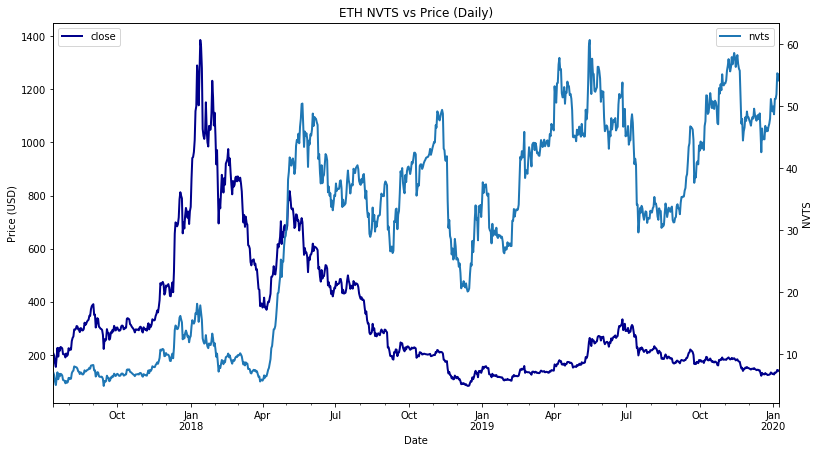

In [17]:
# Plot NVTS vs price
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
df_eth["close"].iloc[dma:].plot(color='darkblue', linewidth=2)
ax1 = ax.twinx()
df_eth["nvts"].iloc[dma:].plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("NVTS")
plt.title(f"ETH NVTS vs Price (Daily)")

Text(0.5, 1.0, 'ETH Active addresses vs Price (Daily)')

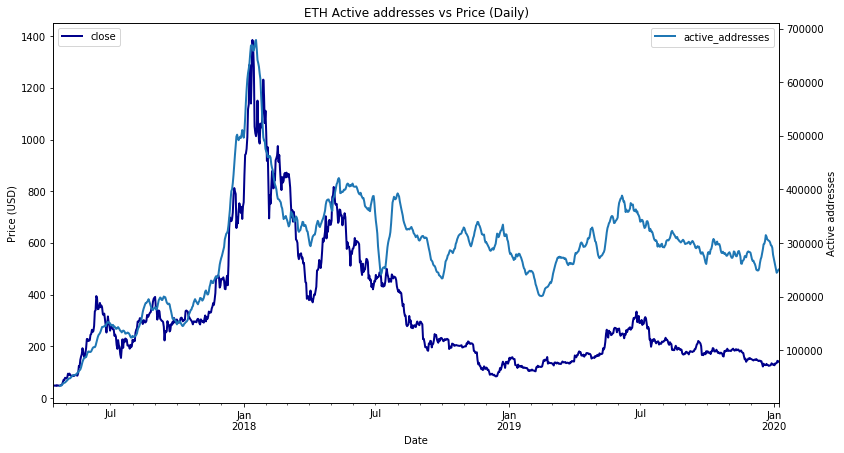

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
df_eth["close"].plot(linewidth=2, color='darkblue')
ax1 = ax.twinx()
# Plot active addresses as a MA to reduce noise
df_eth["active_addresses"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("Active addresses")
plt.title(f"ETH Active addresses vs Price (Daily)")

In [19]:
df_eth["large_txn_pct"] = df_eth["large_transaction_count"] / df_eth["transaction_count"] * 100

Text(0.5, 1.0, 'ETH Percentage of large transactions vs Price (Daily)')

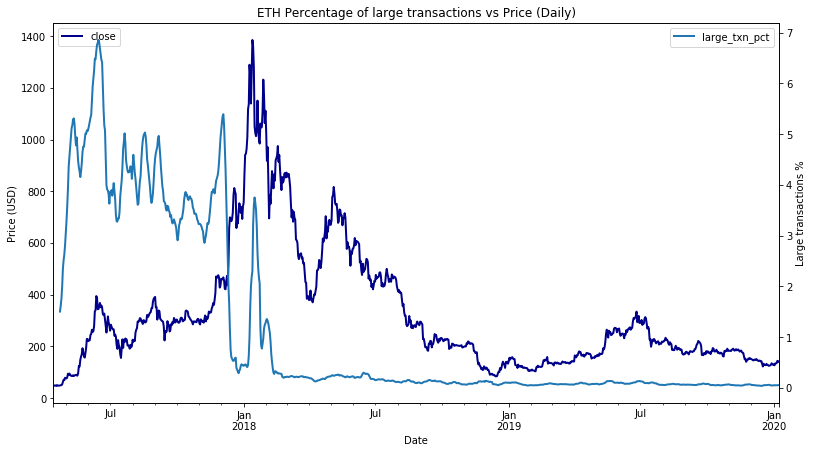

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))
df_eth["close"].plot(linewidth=2, color='darkblue')
ax1 = ax.twinx()
# Plot percentage of large transactions as a MA to reduce noise
df_eth["large_txn_pct"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("Large transactions %")
plt.title(f"ETH Percentage of large transactions vs Price (Daily)")

In [21]:
large_txn_dollar = 100000
df_eth[f"large_txn_eth"] = df_eth["large_transaction_count"] * large_txn_dollar / df_eth["close"]

Text(0.5, 1.0, 'Large transactions in ETH vs Price')

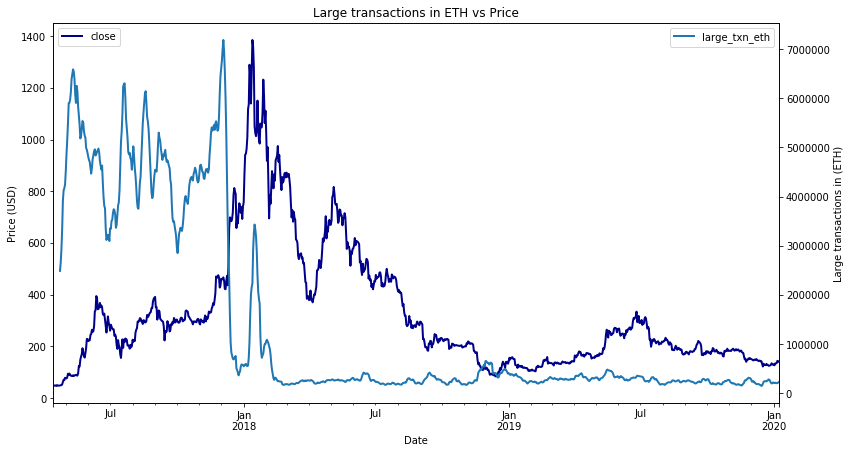

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7), sharex='row')
df_eth["close"].plot(linewidth=2, color="darkblue")
ax1 = ax.twinx()
df_eth[f"large_txn_eth"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)

ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel(f"Large transactions in (ETH)")
plt.title(f"Large transactions in ETH vs Price")

## LTC

In [23]:
df_ltc = get_blk_px_data(api_key, "LTC", limit)

In [24]:
df_ltc = calc_nvts(df_ltc, dma)

Text(0.5, 1.0, 'LTC NVTS vs Price (Daily)')

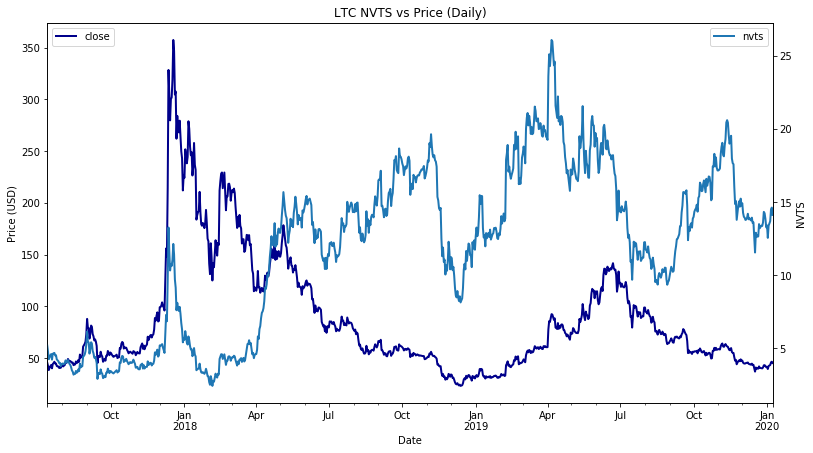

In [25]:
# Plot NVTS vs price
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
df_ltc["close"].iloc[dma:].plot(color='darkblue', linewidth=2)
ax1 = ax.twinx()
df_ltc["nvts"].iloc[dma:].plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("NVTS")
plt.title(f"LTC NVTS vs Price (Daily)")

Text(0.5, 1.0, 'LTC Active addresses vs Price (Daily)')

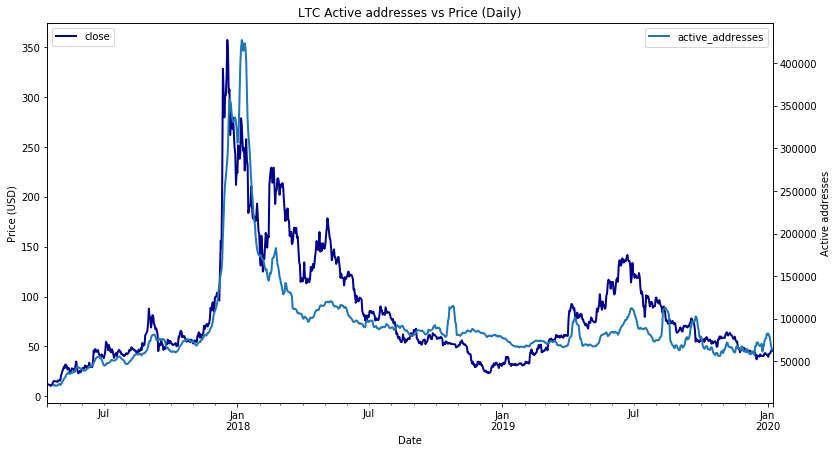

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13,7))
df_ltc["close"].plot(linewidth=2, color='darkblue')
ax1 = ax.twinx()
# Plot active addresses as a MA to reduce noise
df_ltc["active_addresses"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("Active addresses")
plt.title(f"LTC Active addresses vs Price (Daily)")

In [27]:
df_ltc["large_txn_pct"] = df_ltc["large_transaction_count"] / df_ltc["transaction_count"] * 100

Text(0.5, 1.0, 'LTC Percentage of large transactions vs Price (Daily)')

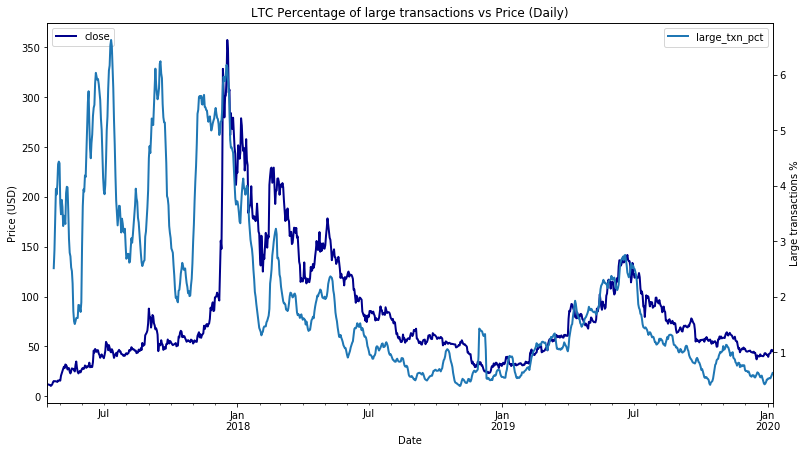

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7))
df_ltc["close"].plot(linewidth=2, color='darkblue')
ax1 = ax.twinx()
# Plot percentage of large transactions as a MA to reduce noise
df_ltc["large_txn_pct"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)
ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel("Large transactions %")
plt.title(f"LTC Percentage of large transactions vs Price (Daily)")

In [29]:
large_txn_dollar = 100000
df_ltc[f"large_txn_ltc"] = df_ltc["large_transaction_count"] * large_txn_dollar / df_ltc["close"]

Text(0.5, 1.0, 'Large transactions in LTC vs Price')

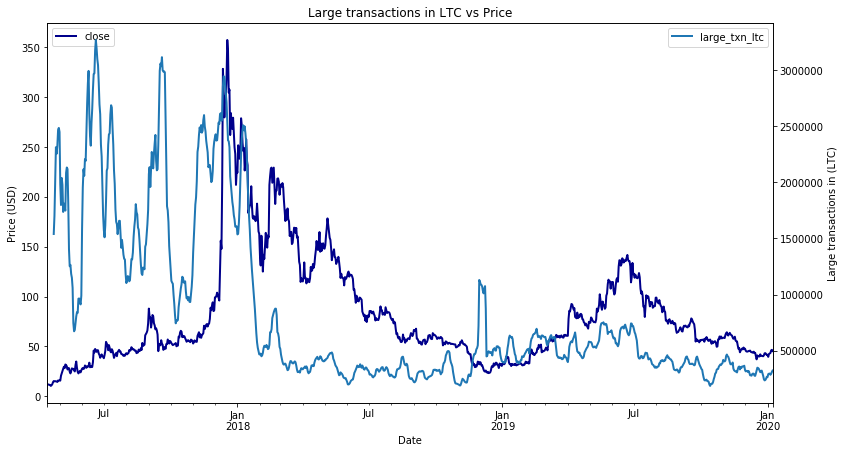

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 7), sharex='row')
df_ltc["close"].plot(linewidth=2, color="darkblue")
ax1 = ax.twinx()
df_ltc[f"large_txn_ltc"].rolling(window=10).mean().plot(ax=ax1, linewidth=2)

ax.legend(loc=2)
ax1.legend(loc=0)
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax1.set_ylabel(f"Large transactions in (LTC)")
plt.title(f"Large transactions in LTC vs Price")

## Find out more

Feel free to play around with the API yourself and read the full documentation on the [CryptoCompare Blockchain Fundamental API here](https://min-api.cryptocompare.com/documentation?key=Blockchain&cat=blockchainListOfCoins), or contact us on data@cryptocompare.com.